In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

%matplotlib inline

# Data

In [10]:
hourly_mean = pd.read_csv('../../data/Fernando/hourly_mean.csv')
df_train = pd.read_csv('../../data/Fernando/df_train.csv')
log_data = pd.read_csv('../../data/Fernando/log_data.csv')
df_test = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_CECOVEL_test.csv')

In [3]:
hourly_mean.head()

,datetime,Valor,Dia,Ano,Hora,Minuto
0,2015-03-02 00:00:00,1.000,1.000,1.000,1.000,1.000
1,2015-03-02 01:00:00,32.565,32.565,32.565,32.565,32.565
2,2015-03-02 02:00:00,38.347,38.347,38.347,38.347,38.347
3,2015-03-02 03:00:00,26.616,26.616,26.616,26.616,26.616
4,2015-03-02 04:00:00,17.202,17.202,17.202,17.202,17.202


In [4]:
df_train.head()

,Valor,timestamp,Dia,Mês,Ano,Hora,Minuto,datetime
0,1.000,2015-03-02T00:00,2,Mar,2015,0,0,2015-03-02 00:00:00
1,32.565,2015-03-02T01:00,2,Mar,2015,1,0,2015-03-02 01:00:00
2,38.347,2015-03-02T02:00,2,Mar,2015,2,0,2015-03-02 02:00:00
3,26.616,2015-03-02T03:00,2,Mar,2015,3,0,2015-03-02 03:00:00
4,17.202,2015-03-02T04:00,2,Mar,2015,4,0,2015-03-02 04:00:00


In [5]:
log_data.head()

,datetime,Valor
0,2015-03-02 00:00:00,0.000000
1,2015-03-02 01:00:00,3.483238
2,2015-03-02 02:00:00,3.646676
3,2015-03-02 03:00:00,3.281513
4,2015-03-02 04:00:00,2.845026


In [8]:
hourly_mean.set_index('datetime',inplace=True)
hourly_mean.head()

,Valor,Dia,Ano,Hora,Minuto
datetime,,,,,
2015-03-02 00:00:00,1.000,1.000,1.000,1.000,1.000
2015-03-02 01:00:00,32.565,32.565,32.565,32.565,32.565
2015-03-02 02:00:00,38.347,38.347,38.347,38.347,38.347
2015-03-02 03:00:00,26.616,26.616,26.616,26.616,26.616
2015-03-02 04:00:00,17.202,17.202,17.202,17.202,17.202


In [9]:
log_data.set_index('datetime',inplace=True)
log_data.head()

,Valor
datetime,
2015-03-02 00:00:00,0.000000
2015-03-02 01:00:00,3.483238
2015-03-02 02:00:00,3.646676
2015-03-02 03:00:00,3.281513
2015-03-02 04:00:00,2.845026


In [11]:
df_test.head()

,value,timestamp
0,27.298,2016-03-01T00:00
1,176.818,2016-03-01T01:00
2,137.341,2016-03-01T02:00
3,116.532,2016-03-01T03:00
4,84.029,2016-03-01T04:00


In [14]:
df_test.columns = ['Valor', 'timestamp']

In [15]:
df_test.head()

,Valor,timestamp
0,27.298,2016-03-01T00:00
1,176.818,2016-03-01T01:00
2,137.341,2016-03-01T02:00
3,116.532,2016-03-01T03:00
4,84.029,2016-03-01T04:00


# Modelo Trivial ou de Persistência

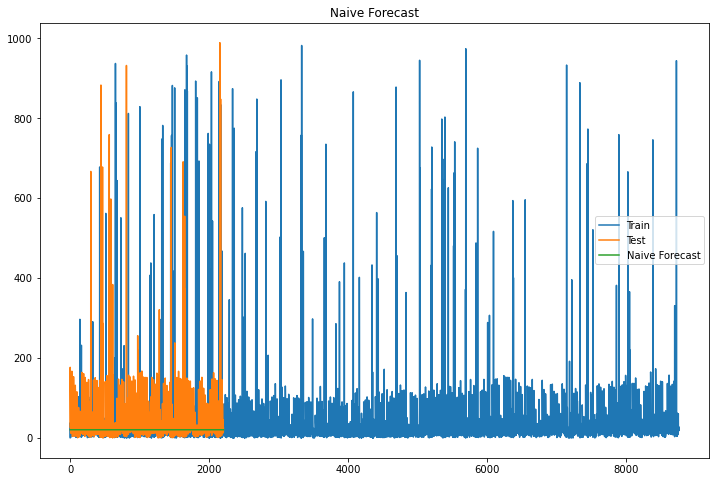

In [16]:
#TODO: resample hora a hora do teste e comparar com o de treino

dd = np.asarray(df_train['Valor'])
y_hat = df_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(df_train.index, df_train['Valor'], label='Train')
plt.plot(df_test.index,df_test['Valor'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(df_test['Valor'], y_hat.naive))
print(rms)

67.2682189292732


In [ ]:
# Comparar com ela transformada

# Modelo de Alisamento Exponencial

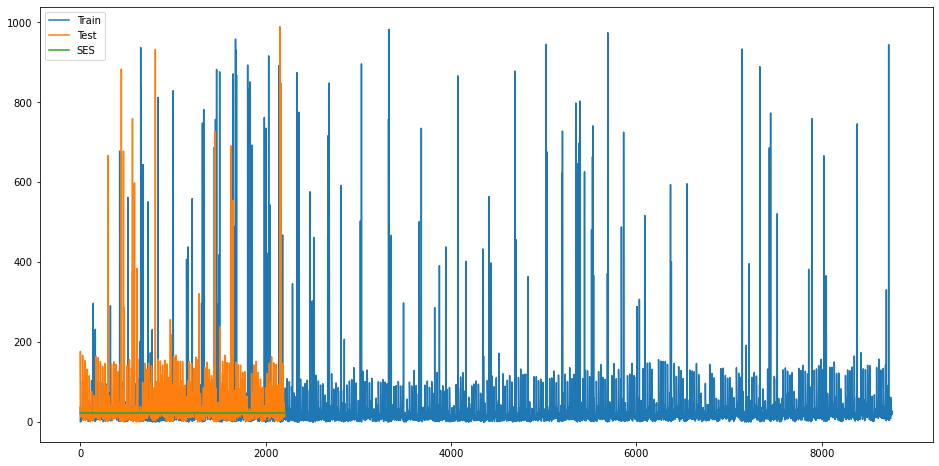

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = df_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(df_train['Valor'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot(df_train['Valor'], label='Train')
plt.plot(df_test['Valor'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [21]:
rms = sqrt(mean_squared_error(df_test['Valor'], y_hat_avg['SES']))
print(rms)

66.6800091881856


# Modelo de Holt's-Winter

/home/fran/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


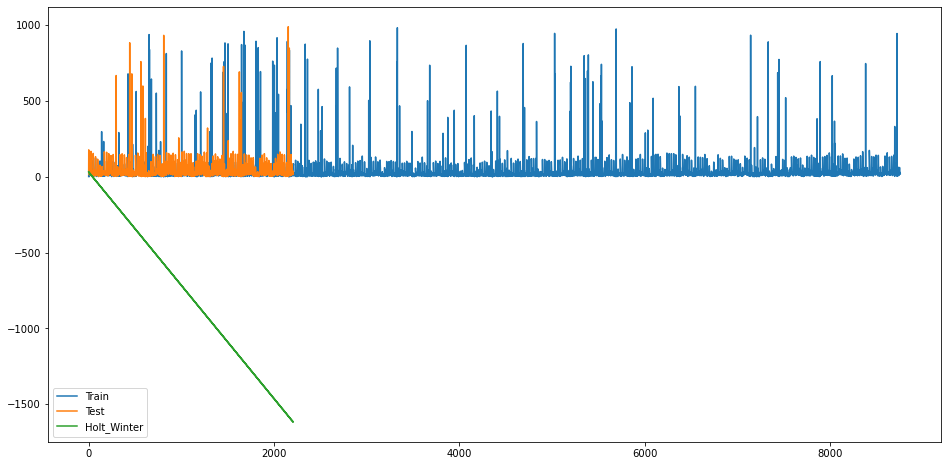

In [31]:
y_hat_avg = df_test.copy()
fit1 = ExponentialSmoothing(np.asarray(df_train['Valor']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot( df_train['Valor'], label='Train')
plt.plot(df_test['Valor'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [32]:
rms = sqrt(mean_squared_error(df_test['Valor'], y_hat_avg.Holt_Winter))
print(rms)

961.8907445953669
